# makemore 3
Following a tutorial from [Andrej Karpathy](https://karpathy.ai/):
- [The spelled-out intro to language modeling: Building makemore Part 3: Activations & Gradients, BatchNorm](https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

# Setup

In [ ]:
# !pip install torch matplotlib graphviz

# Load the data

In [4]:
words = open('names.txt', 'r').read().splitlines()

# Starting checkpoint
This is basically the state at which we left off last time. Make a model, train it on 3-grams or characters, and generate real-sounding names.

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

In [6]:
# build the dataset splits
block_size = 3 # the N-gram context size

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [14]:
# MLP model
n_embd = 10 # number of dimensions for the embedding
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [43]:
# hyper params
batch_size = 32
max_steps = 200000
learning_rate = 0.1
lossi = []

# train
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = learning_rate if i < 100000 else learning_rate / 10 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


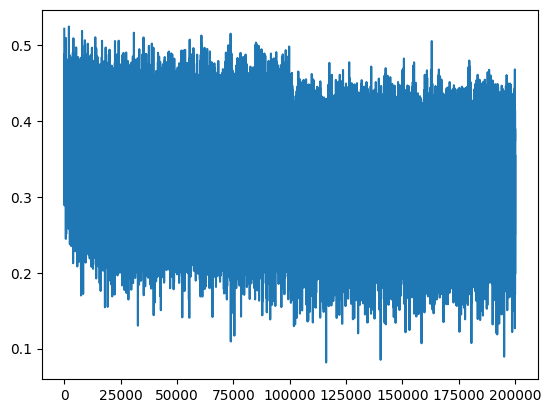

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split:5} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0696
val   loss: 2.1311


In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

junide.
jaycand.
presayleigh.
kai.
ronorian.
arett.
samela.
zamilena.
jadeyaire.
amellseen.
evy.
artez.
aveumahaf.
demmerppynsleigh.
ann.
core.
yaenacharesabille.
korin.
wyn.
neviansh.


# Improvements

## Starting loss
The vocabulary size is 27, so by default we expect the proba for each character to be $1 \over 27$

In [23]:
- torch.tensor(1.0/vocab_size).log()

tensor(3.2958)

But our starting loss was `27.8817` (instead of `3.2958`). So the starting weights are very confidently wrong.

To prevent that we want to squash the initialization values of the weight. Ideally we want every weights to be close to 0 but not exactly 0.0 to break symmetry.

In [41]:
# refactored model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)              * 0.01
b2 = torch.randn(vocab_size, generator=g)                          * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

## tanh is too active
Too many elements get normalized to `-1` or `1` by the `torch.tanh()`. It means that our data have too extreme values. This is bad because the derivative of `tanh()` at `-1` or `1` is `0`. So the backpropagation gets nullified. Intuitively this happen because `tanh(500) ~= 1.0` and `tanh(50) ~= 1`. Why bother changing the value from `500` to `50` if it will output `1.0` regardless, and it wont influnce the loss.

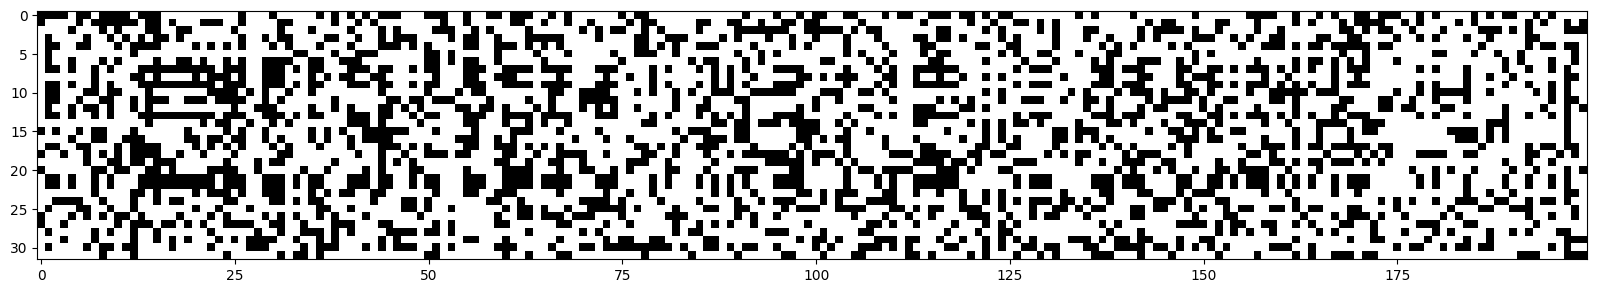

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

All the white pixels have value `> 0.99` so they destroy the backpropagation gradient.

NOTE: If we ever had an entire column being white. The corresponding neuron would be a `dead neuron` because there would be no way forward to train this neuron (because all gradients would be null).

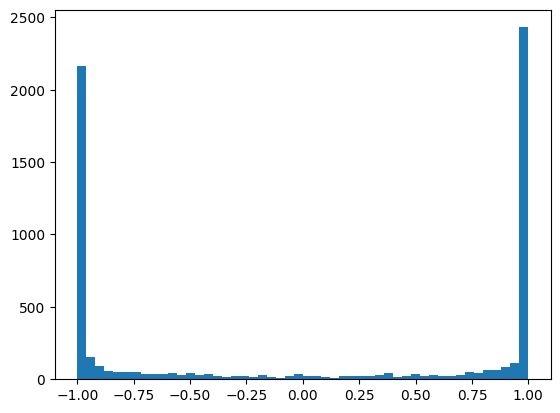

In [45]:
_ = plt.hist(h.view(-1).tolist(), 50)

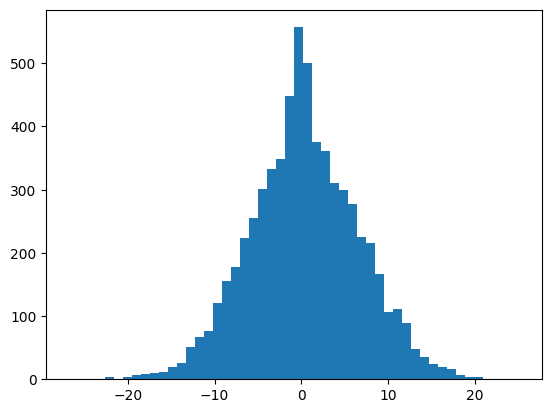

In [46]:
_ = plt.hist(hpreact.view(-1).tolist(), 50)

We can fix that by also scalling the initialization values of `W1` and `b1` by a factor of `0.1` (e.g. `W1 *= 0.1; b1 *= 0.01`).

### Automatic the initial value scaling

x.mean()=tensor(0.0076) x.std()=tensor(1.0009)
y.mean()=tensor(-0.0058) y.std()=tensor(3.1436)


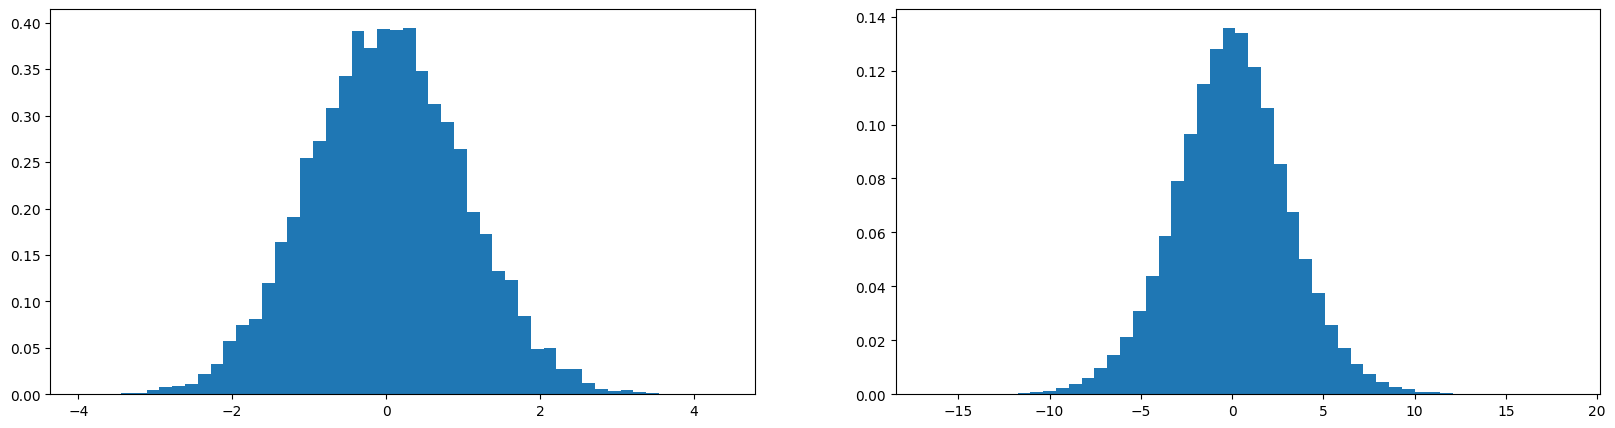

In [48]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(f'{x.mean()=} {x.std()=}')
print(f'{y.mean()=} {y.std()=}')
plt.figure(figsize=(20, 5))
plt.subplot(121)
_ = plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True)

The matrix multiplication `x @ w` causes the standard deviation to increate. To prevent that the `w` matrix values should scaled by a factor of the square root of the `fan_in` (aka. input dimension) $\sqrt{fan\_in}$ (e.g. `w /= 10**0.5`).

x.mean()=tensor(-0.0199) x.std()=tensor(1.0033)
y.mean()=tensor(-0.0030) y.std()=tensor(0.9909)


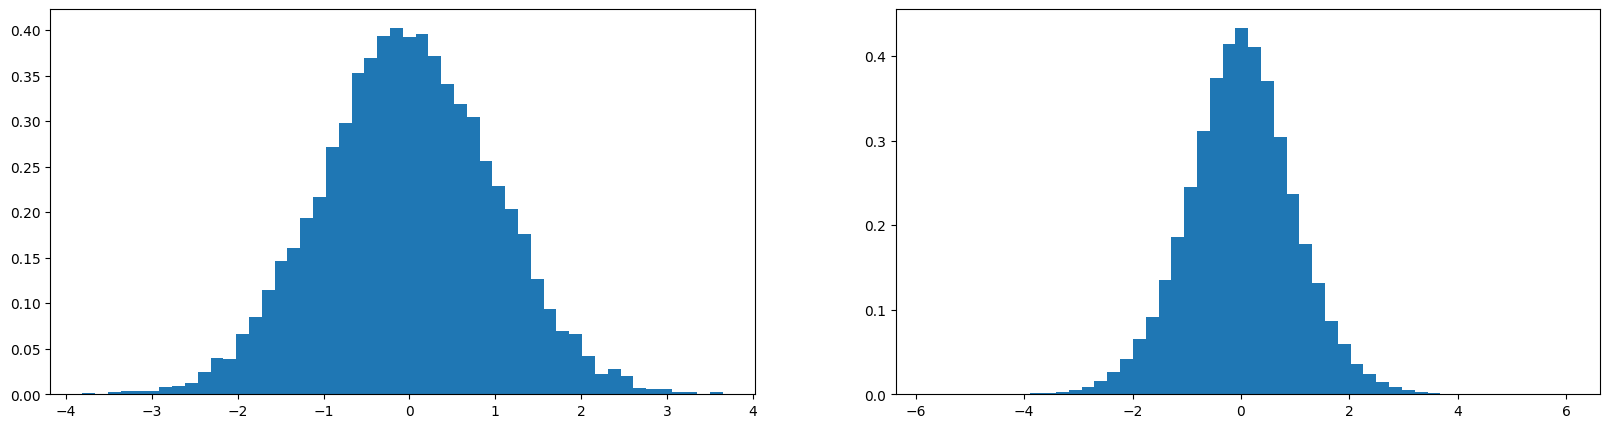

In [49]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(f'{x.mean()=} {x.std()=}')
print(f'{y.mean()=} {y.std()=}')
plt.figure(figsize=(20, 5))
plt.subplot(121)
_ = plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True)

PyTorch has `torch.nn.init.kaiming_normal_` to automatically compute good initial weights based on the `fan_in`, and your non-linearity (aka. normalization function, i.e ReLU, Tanh).

### batch normalization
see BatchNorm paper: https://arxiv.org/abs/1502.03167

TL;DR: we want to make the pre-activation values (ie. `hpreact`) to be gaussian-ly distributed to maximize how meaningful our `tanh()` results will be.

Note: this as the side effect to act as a regularization effect to prevent overfitting because we update weights based on the minibach and not a single `(X, Y)` pair. This creates complication and potential bugs, but also has the nice side effect of preventing too much overfitting.

In [54]:
print(f'{hpreact.shape=}')
print(f'{hpreact.mean(0, keepdim=True).shape=}')
print(f'{hpreact.std(0, keepdim=True).shape=}')

gaussian_distributed_hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

hpreact.shape=torch.Size([32, 200])
hpreact.mean(0, keepdim=True).shape=torch.Size([1, 200])
hpreact.std(0, keepdim=True).shape=torch.Size([1, 200])


We want the distribution to be adjusted to the gaussian at initialization, but we still want the network to be able to learn. By introducing a batch normalization gain `bngain` and a batch normalization bias `bnbias` to `1` and `0` we have the first run be `1 * value + 0` and later on the gain and bias will change scaling and shifting the distribution to learned values.

In [55]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

gaussian_distributed_hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

NOTE: At this point I was having a bug. While on paper it seems like a nice addition, and in practice the `loss` remain low, using the newly trained net to generate names gave way worst (or maybe Polish) names:

- junndth.
- stagadon.
- zlynnedin.
- gurtnetorstisster.
- stinntastifflevanckabdunnmordellssophendraftylindtumthaffrtumjclonnslejhostellanisaysengcklynnakhinergmiknmwynslevgaasnrajfilspsushfdsonffrttagilzarthannathster.
- srell.
- stemuksistjemumckazvussiannahvorgarrrutshnasstta.
- splynsloluward.
- zavarondzthemsilyannahslindss.
- trvostynkyzsaloeverinancekshlejseemriannerryaxtmurzaodrickdzeonjalgkpvighadtezrisshly.
- jumslelvynn.
- sthimdhannakhtte.
- tracnobornavinapspprrthn.
- styncsyah.
- klarghnnkcaszannjchskartanverryderiyannesrdan.
- tadon.
- brshtugynd.
- zbusthastilnjtyllyndstergandoshleab.
- lordeslyfadma.
- gumfstofadvegh.

This was due to updating the code for training and for loss computation but not for generation, so add these `bngain` and `bnbias` everywhere 😝.

# Improved version

In [88]:
# MLP model
n_embd = 10 # number of dimensions for the embedding
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.nn.init.kaiming_normal_(torch.empty((n_embd * block_size, n_hidden)), mode='fan_in', nonlinearity='tanh')
# because of the normalization layer this becomes a no-op
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [89]:
# hyper params
batch_size = 32
max_steps = 200000
learning_rate = 0.1
lossi = []

# train
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # because of the normalization layer `b1` became a no-op
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # compute the running mean and std
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = learning_rate if i < 100000 else learning_rate / 10 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3018
  10000/ 200000: 2.4316
  20000/ 200000: 1.9544
  30000/ 200000: 2.0502
  40000/ 200000: 1.7349
  50000/ 200000: 1.7626
  60000/ 200000: 2.5217
  70000/ 200000: 2.0531
  80000/ 200000: 2.1924
  90000/ 200000: 2.0306
 100000/ 200000: 2.3727
 110000/ 200000: 2.5674
 120000/ 200000: 2.0845
 130000/ 200000: 2.2001
 140000/ 200000: 2.4930
 150000/ 200000: 2.0083
 160000/ 200000: 1.8854
 170000/ 200000: 1.8768
 180000/ 200000: 1.9759
 190000/ 200000: 2.0565


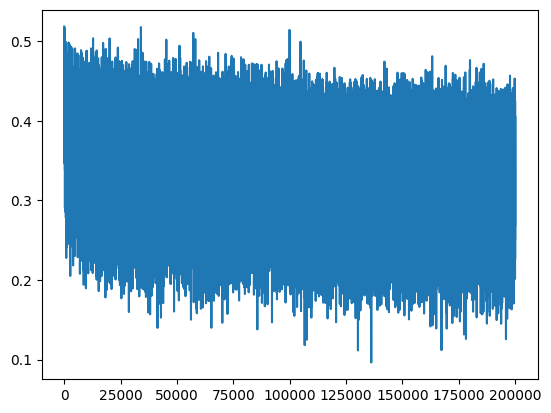

In [90]:
plt.plot(lossi)

In [91]:
# calibrate the batch norm by hand
def calibrate_bn_by_hand():
    with torch.no_grad():
        emb = C[Xtr]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # + b1 # because of the normalization layer `b1` became a no-op
        bnmean = hpreact.mean(0, keepdim=True)
        bnstd = hpreact.std(0, keepdim=True)
    return bnmean, bnstd

# We are going to use the running mean and std instead
# bnmean, bnstd = calibrate_bn_by_hand()

In [92]:

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # because of the normalization layer `b1` became a no-op
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split:5} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0586
val   loss: 2.1057


In [93]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 # + b1 # because of the normalization layer `b1` became a no-op
        # hpreact = bngain * (hpreact - hpreact.mean()) / hpreact.std() + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

junide.
jakarie.
presayve.
nar.
jimrito.
sabe.
ter.
kalania.
zamilena.
jededaine.
imel.
sera.
evy.
arterinveum.
kyn.
demmercentsy.
jarsand.
cora.
yarion.
kaesabi.


# PyTorch-ify the code

In [174]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # statistics (not trained with backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the running statistics
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []
        

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # make the output layer less confident
    # layers[-1].weight *= 0.1 # replaced because of `BatchNorm1d()`
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5.0/3
        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of params
for p in parameters:
    p.requires_grad = True

47351


In [175]:
# hyper params
batch_size = 32
max_steps = 200000
learning_rate = 0.1
lossi = []
ud = [] # update to data ratio

# train
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # REMOVE: DEBUG
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = learning_rate if i < 100000 else learning_rate / 10 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # REMOVE: DEBUG

      0/ 200000: 3.2880


layer 1 (   Tanh   ): mean -0.04 std 0.77, saturated: 21.97%
layer 4 (   Tanh   ): mean +0.01 std 0.64, saturated:  2.97%
layer 7 (   Tanh   ): mean +0.00 std 0.64, saturated:  2.44%
layer 10 (   Tanh   ): mean -0.00 std 0.64, saturated:  2.19%
layer 13 (   Tanh   ): mean -0.00 std 0.64, saturated:  2.22%


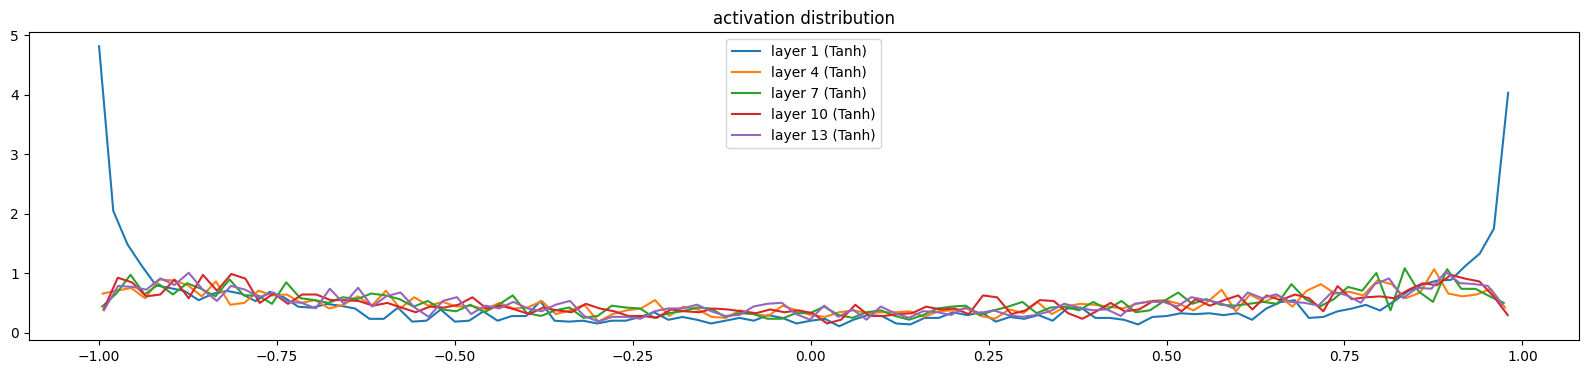

In [176]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__:^10}): mean {t.mean():+.2f} std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:>5.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
_ = plt.title('activation distribution')

layer 1 (   Tanh   ): mean +0.000000 std 3.444823e-03
layer 4 (   Tanh   ): mean +0.000000 std 3.350700e-03
layer 7 (   Tanh   ): mean -0.000000 std 3.005853e-03
layer 10 (   Tanh   ): mean -0.000000 std 2.766106e-03
layer 13 (   Tanh   ): mean -0.000000 std 2.628895e-03


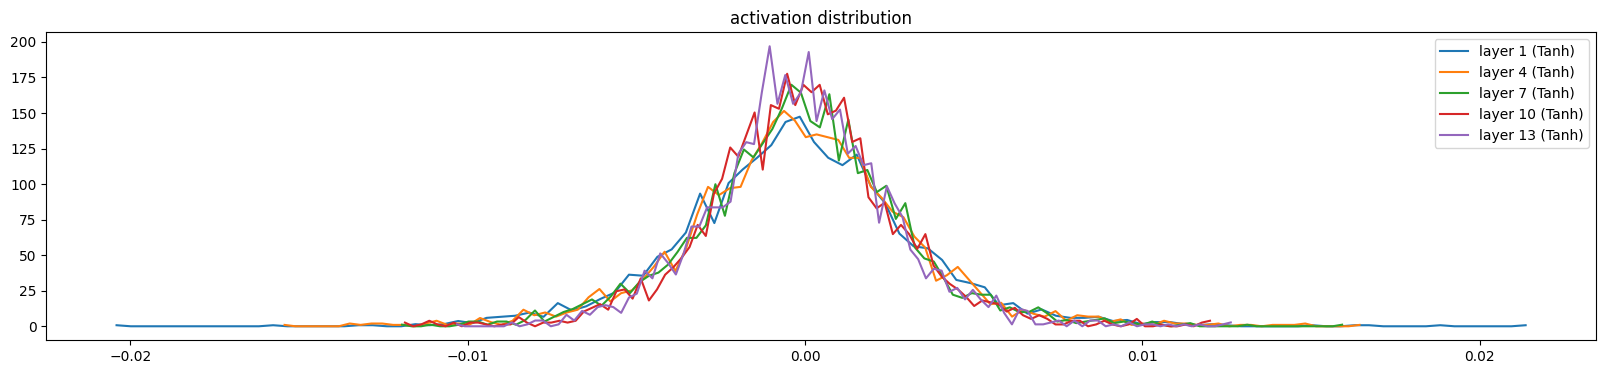

In [177]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:^10}): mean {t.mean():+f} std {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
_= plt.title('activation distribution')

weight   (27, 10) | mean +0.000174 | std 1.054002e-02 | grad:data ratio 1.053653e-02
weight  (30, 100) | mean +0.000171 | std 9.323096e-03 | grad:data ratio 2.983445e-02
weight (100, 100) | mean +0.000105 | std 8.153873e-03 | grad:data ratio 4.875960e-02
weight (100, 100) | mean +0.000045 | std 6.798573e-03 | grad:data ratio 4.030497e-02
weight (100, 100) | mean -0.000144 | std 5.924115e-03 | grad:data ratio 3.529168e-02
weight (100, 100) | mean +0.000039 | std 5.268642e-03 | grad:data ratio 3.138035e-02
weight  (100, 27) | mean -0.000203 | std 1.055290e-02 | grad:data ratio 6.330074e-02


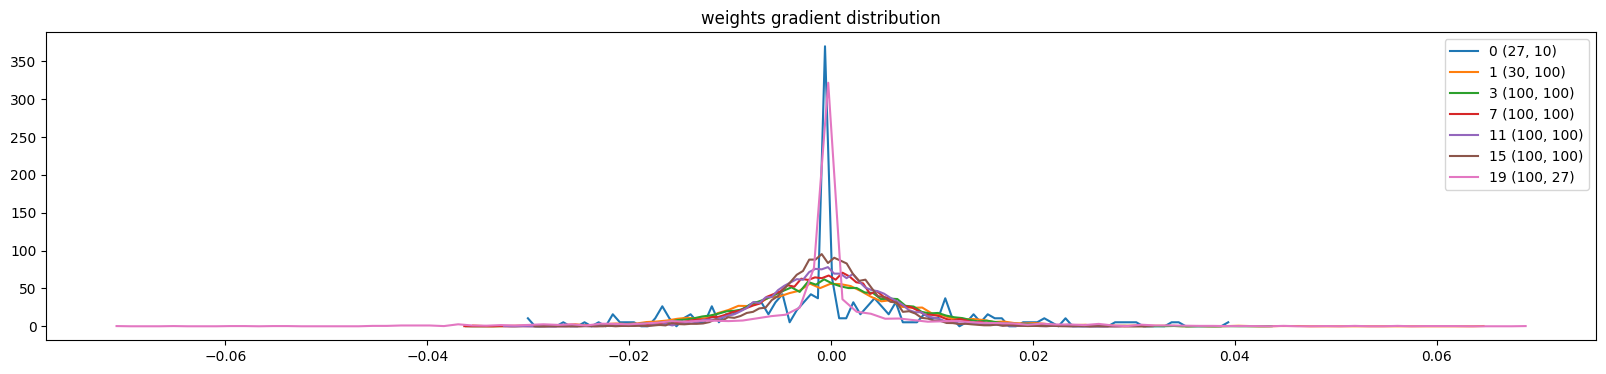

In [178]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)!s:>10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
_= plt.title('weights gradient distribution')

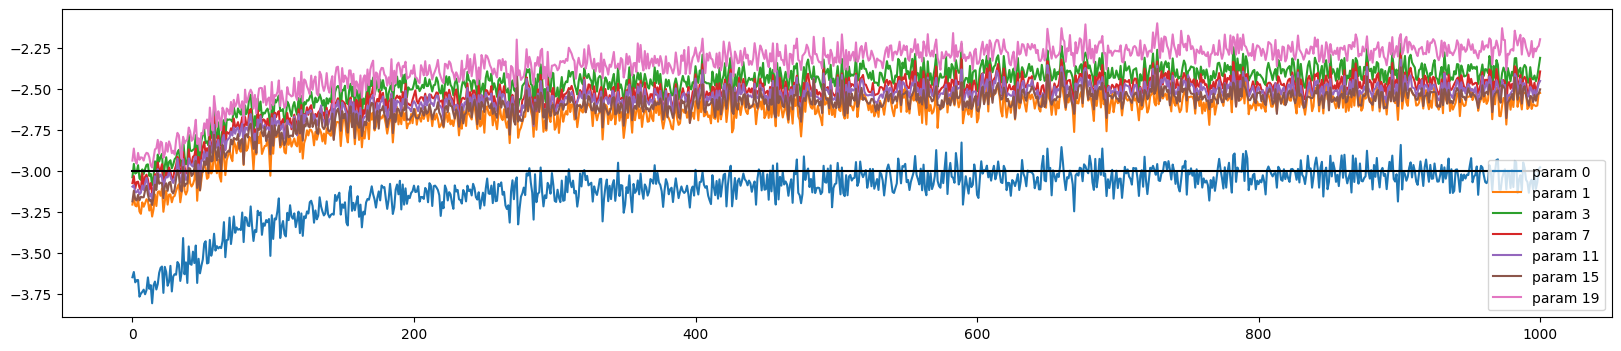

In [179]:
# how fast are we training / how big are the gradients updates
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([u[i] for u in ud])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ration should be ~1e-3, so add a black line for comparison
_ = plt.legend(legends)